<a href="https://colab.research.google.com/github/pragmalingu/experiments/blob/02_BERT/Evaluation/Comparison_BERT_vs_Standard_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second Comparison: Sentence Embeddings vs. Standard Search 

For our second experiment we connect the Notebook to an Elasticsearch instance and compare a standard Elasticsearch operator with our BERT approach. Therefore we got the vector representations for the documents from BERT and indexed them using an Elasticsearch built-in knn algorithm. 
We tried this approach in the whole document texts as well as on the document titles.

**Bi-Directional Encoder Representation from Transformer (BERT)**

BERT is an approach of using large pretrained neural networks with some exceptional solutions to get the vectors from texts, which we can use with some similarity metrics like cosine similarity to compare meaning of these texts.

(By the way these networks are frequently used as a backbone or part of ensemble of models to solve some NLP tasks like Question Answering, Ranking, Named Entitity Recognition, etc.)

["I'm brave enough to read the paper on BERT"](https://arxiv.org/abs/1810.04805)

In [1]:
#@title Start the connection to our Elasticsearch instance { display-mode: "form" }
!pip install Elasticsearch
from elasticsearch import Elasticsearch
from datetime import datetime
es = Elasticsearch(["pragmalingu:ekFYkgqIeeKZN6tbehsZ@ssh.pragmalingu.de:9200"])
response = es.cat.indices()

     |████████████████████████████████| 225kB 2.8MB/s 


### Download pretrained BERT model

In [2]:
!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
import torch

model = SentenceTransformer('bert-base-nli-mean-tokens')

# using gpu to boost inference if it's possible
if torch.cuda.is_available():
  model.to('cuda')

#Change the length to max possible length (based on gpu memory)
model.max_seq_length = 364

print('Max Sequence Length:', model.max_seq_length)

     |████████████████████████████████| 71kB 2.2MB/s 
     |████████████████████████████████| 1.1MB 7.8MB/s 
     |████████████████████████████████| 890kB 25.8MB/s 
     |████████████████████████████████| 1.1MB 45.3MB/s 
     |████████████████████████████████| 3.0MB 47.7MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-cp36-none-any.whl size=101996 sha256=9331aab7833ab8d3030bdb41002b8dbbd38497a70d78b7048ff2c83435c31be6
  Stored in directory: /root/.cache/pip/wheels/27/ec/b3/d12cc8e4daf77846db6543033d3a5642f204c0320b15945647
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=65f2f8e9109eaefb50b8a426845ee530c11a9fb7d161ac207af743fce9a43929
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


100%|██████████| 405M/405M [00:17<00:00, 23.8MB/s]


Max Sequence Length: 364


## Parse Data

Get different corpora, format them and feed them to elasticsearch

### ADI Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/adi/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/adi_corpus/ADICorpus.ipynb) or for parsing in generel read [this guide](https://). 

**Data Processing**

In [3]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/ZWpy29gH4D2sADY/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variables
PATH_TO_ADI_QRY = '/content/ADI.QRY'
PATH_TO_ADI_REL = '/content/ADI.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np


# get the query files

ID_marker = re.compile('\.I')

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read().replace('\n'," ")
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

adi_qry_list = get_data(PATH_TO_ADI_QRY, ID_marker)

# process query file    

qry_chunk_start = re.compile('\.W')
adi_qry_data = defaultdict(dict)

for n in range(0,len(adi_qry_list)-1):
  line = adi_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  adi_qry_data[n+1]['question'] = question

# process relevance assesment

adi_rel_data = open(PATH_TO_ADI_REL)
adi_np = np.loadtxt(adi_rel_data, dtype=float)

adi_rel = defaultdict(list)
for row in adi_np:
  adi_rel[int(row[0])].append(int(row[1])) 

--2020-10-20 13:48:20--  https://nextcloud.samyateia.de/index.php/s/ZWpy29gH4D2sADY/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57344 (56K) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]  56.00K   277KB/s    in 0.2s    

2020-10-20 13:48:21 (277 KB/s) - ‘download’ saved [57344/57344]



### CACM Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Data Processing**

In [4]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/s4WQLTc7DLYsAaZ/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_CACM_QRY = '/content/query.text'
PATH_TO_CACM_REL = '/content/qrels.text'
PATH_TO_CACM_COMMON_WORDS = '/content/common_words'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

# get the query files

ID_marker = re.compile('^\.I',re.MULTILINE)

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cacm_qry_list = get_data(PATH_TO_CACM_QRY, ID_marker)

# process the query data

qry_chunk_start = re.compile('^\.W\n',re.MULTILINE)
cacm_qry_data = defaultdict(dict)

for n in range(0,len(cacm_qry_list)-1):
  line = cacm_qry_list[n+1]
  _ , question = re.split(qry_chunk_start,line)
  cacm_qry_data[n+1]['question'] = question

# process the relevance assesment data
cacm_rel = defaultdict(list)

with open (PATH_TO_CACM_REL,'r') as f:
  for line in f:
    line = re.split(' ',line)
    cacm_rel[int(line[0])].append(line[1])

--2020-10-20 13:48:21--  https://nextcloud.samyateia.de/index.php/s/s4WQLTc7DLYsAaZ/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2221056 (2.1M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   2.12M  2.97MB/s    in 0.7s    

2020-10-20 13:48:22 (2.97 MB/s) - ‘download’ saved [2221056/2221056]



### CISI Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cisi/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/cisi_corpus/CISICorpus.ipynb) or for parsing in generel read [this guide](https://).

**Data Processing**

In [5]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/ibPgbdqsstrWEAa/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variablesDownload and unzip data.
PATH_TO_CISI_QRY = '/content/CISI.QRY'
PATH_TO_CISI_REL = '/content/CISI.REL'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np

# get the and query files

ID_marker = re.compile('^\.I',re.MULTILINE)

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE,'r') as f:
    text = f.read()
    lines = re.split(marker,text)
    lines.pop(0)
  return lines

cisi_qry_list = get_data(PATH_TO_CISI_QRY, ID_marker)

# process query file  

qry_chunk_start = re.compile('[\n]\.W')

cisi_qry_data = defaultdict(dict)

for line in cisi_qry_list:
  id , question = re.split(qry_chunk_start,line)
  id = re.findall('\d{1,3}',id)[0]
  cisi_qry_data[id]['question'] = question

# process the relevance assesment data
cisi_rel = defaultdict(list)

with open (PATH_TO_CISI_REL,'r') as f:
  for line in f:
    line = line.replace(' ','\t')
    line = re.split('\t',line)
    line = list(filter(None, line))
    cisi_rel[str(line[0])].append(str(line[1]))

--2020-10-20 13:48:23--  https://nextcloud.samyateia.de/index.php/s/ibPgbdqsstrWEAa/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2385920 (2.3M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   2.28M  3.18MB/s    in 0.7s    

2020-10-20 13:48:24 (3.18 MB/s) - ‘download’ saved [2385920/2385920]



### Cranfield Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/cran/).  <br>
For detailed information about the parsing of this corpus look at [ this Notebook](https://colab.research.google.com/github/pragmalingu/private_experiments/blob/cranfield_corpus/CranfieldCorpus.ipynb) or for parsing in generel read [this guide](https://).

**Data Processing**

In [6]:
#download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/ePSxPpLELCWteeL/download
!tar -xf download
!rm download

#set paths for the downloaded data
PATH_TO_CRAN_QRY = '/content/cran.qry'
PATH_TO_CRAN_REL = '/content/cranqrel'

#defaultdict calls a factory function to supply missing values 
from collections import defaultdict

#regular expression operations
import re 

def get_data(PATH_TO_FILE, marker):
  """
  Reads file and spilts text into entries at the ID marker '.I'.
  First entry is empty, so it's removed.
  'marker' contains the regex at which we want to split
  """
  with open (PATH_TO_FILE, 'r') as f:
    text = f.read().replace('\n', " ")
    lines = re.split(marker, text)
    lines.pop(0)
  return lines

#get the query files
ID_marker = re.compile('\.I')
cran_qry_list = get_data(PATH_TO_CRAN_QRY, ID_marker)

#process query file
cran_qry_data = defaultdict(dict)
qry_chunk_start = re.compile('\.W')

for n in range(0, len(cran_qry_list)-1):
  line = cran_qry_list[n+1]
  _ , question = re.split(qry_chunk_start, line)
  cran_qry_data[n+1]['question'] = question

#process relevance assessments without rating
cran_rel = defaultdict(list)

with open(PATH_TO_CRAN_REL, 'r') as f:
  for line in f:
    line = re.split(' ', line)
    cran_rel[int(line[0])].append(line[1])

--2020-10-20 13:48:25--  https://nextcloud.samyateia.de/index.php/s/ePSxPpLELCWteeL/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1698816 (1.6M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   1.62M  2.28MB/s    in 0.7s    

2020-10-20 13:48:26 (2.28 MB/s) - ‘download’ saved [1698816/1698816]



### LISA Corpus

You can get the corpus from [this link](http://ir.dcs.gla.ac.uk/resources/test_collections/lisa/).  <br>
For detailed information about the format of the files, see the PragmaLingu [ Benchmarks](https://pragmalingu.de/docs/benchmarks/overview)

**Data Processing**

In [7]:
# download and unzip data
!wget https://nextcloud.samyateia.de/index.php/s/Ed8gekyDgpkGGQ6/download
!tar -xf download
!rm download

# set paths to the dowloaded data as variablesDownload and unzip data.

PATH_TO_LISA_QRY = '/content/LISA.QUE'
PATH_TO_LISA_REL = '/content/LISARJ.NUM'

from collections import defaultdict
import re
import json
from io import StringIO
import numpy as np
import os

# get the query files
qry_entry_marker = re.compile('#')

def get_data(PATH_TO_FILES, marker):
  """
  Reads multiple files and spilts text into entries at the entry marker.
  The 'marker' contains the regex at which we want to split
  Pops last element since it's empty.
  """
  with open (PATH_TO_FILES,'r') as f:
    text = f.read().replace('     ','')
    lines = re.split(marker,text)
    lines.pop()
  return lines

lisa_qry_list = get_data(PATH_TO_LISA_QRY, qry_entry_marker)

# process the query data

lisa_qry_data = defaultdict(dict)
# first line is a special case because it doesn't start with a newline
first_line = lisa_qry_list[0]
first_question = ' '.join(first_line[1:])
lisa_qry_data[int(first_line[0])]['question'] = first_question

# after that every line can be handle the same way
for n in range(0,len(lisa_qry_list)-1):
  line = re.split('\n',lisa_qry_list[n+1])
  question = ' '.join(line[2:])
  lisa_qry_data[int(line[1])]['question'] = question

# process relevance assesments
lisa_rel = defaultdict(list)

rel_marker = re.compile('            \n        ')
rel_split = re.compile('\n')

with open (PATH_TO_LISA_REL,'r') as f:
  file = f.read().strip('       ').replace('\n','')
  lines = re.split(' ',file)
  lines = list(filter(None, lines))
  n = 0
  while n < len(lines):
    ID = int(lines[n])
    num_rel = int(lines[n+1])
    rels = lines[(n+2):(n+num_rel+2)]
    lisa_rel[ID].extend(rels)
    n = n+1+num_rel+1

--2020-10-20 13:48:27--  https://nextcloud.samyateia.de/index.php/s/Ed8gekyDgpkGGQ6/download
Resolving nextcloud.samyateia.de (nextcloud.samyateia.de)... 194.55.14.32
Connecting to nextcloud.samyateia.de (nextcloud.samyateia.de)|194.55.14.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4012544 (3.8M) [application/x-gzip]
Saving to: ‘download’

download            100%[===================>]   3.83M  4.71MB/s    in 0.8s    

2020-10-20 13:48:28 (4.71 MB/s) - ‘download’ saved [4012544/4012544]



## Evaluation

### Recall

In this section we only evaluate the Recall scores.

**Multi Match Query**

Here we evaluate the data with the ["multi_match"](https://pragmalingu.de/docs/experiments/experiment1#standard-elasticsearch) option of elastic search:

In [31]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-simple-query-string-query.html 

import json
from collections import defaultdict

adi_index = 'pragmalingu-adi-corpus'
cacm_index = 'pragmalingu-cacm-corpus'
cisi_index = 'pragmalingu-cisi-corpus'
cran_index = 'pragmalingu-cranfield-corpus'
lisa_index = 'pragmalingu-lisa-corpus'

#function to get normal match evaluation body 
def create_query_body_match_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests": '',
      "metric": {
          "recall": {
              "relevant_rating_threshold": 1,
              "k": 20
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : ["title"]}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


#ADI
adi_create_match_recall = create_query_body_match_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_match_recall = json.dumps(adi_create_match_recall)
adi_res_match_recall = es.rank_eval(adi_eval_body_match_recall, adi_index)
#print(json.dumps(adi_res_match_recall, indent=4, sort_keys=True))

#CACM
cacm_create_match_recall = create_query_body_match_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_match_recall = json.dumps(cacm_create_match_recall)
cacm_res_match_recall = es.rank_eval(cacm_eval_body_match_recall,cacm_index)
#print(json.dumps(cacm_res_match_recall, indent=4, sort_keys=True))

#CISI
cisi_create_match_recall = create_query_body_match_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_match_recall = json.dumps(cisi_create_match_recall)
cisi_res_match_recall = es.rank_eval(cisi_eval_body_match_recall, cisi_index)
#print(json.dumps(cisi_res_match_recall, indent=4, sort_keys=True))

#Cranfield
cran_create_match_recall = create_query_body_match_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_match_recall = json.dumps(cran_create_match_recall)
cran_res_match_recall = es.rank_eval(cran_eval_body_match_recall, cran_index)
#print(json.dumps(cran_res_match_recall, indent=4, sort_keys=True))

#LISA
lisa_create_match_recall = create_query_body_match_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_match_recall = json.dumps(lisa_create_match_recall)
lisa_res_match_recall = es.rank_eval(lisa_eval_body_match_recall,lisa_index)
#print(json.dumps(lisa_res_match_recall, indent=4, sort_keys=True))

**BERT Sentence Embeddings on 'title' field**

In [32]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'pragmalingu-bert-title-adi-corpus'
cacm_index = 'pragmalingu-bert-title-cacm-corpus'
cisi_index = 'pragmalingu-bert-title-cisi-corpus'
cran_index = 'pragmalingu-bert-title-cranfield-corpus'
lisa_index = 'pragmalingu-bert-title-lisa-corpus'

# function to get normal match evaluation body 

def create_query_body_bert_title_recall(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "recall": {
            "k" : 20,
            "relevant_rating_threshold": 1,
            #"ignore_unlabeled": "false"
            }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
        "size": 20,
        "query": {
          "knn": {
            "bert_vector_title": {
              "vector": list(model.encode(query_txt['question']).astype(float)),
              "k": 20
            }
          }
        }
      }
      
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


# ADI

adi_create_bert_title_recall = create_query_body_bert_title_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_bert_title_recall = json.dumps(adi_create_bert_title_recall)
adi_res_bert_title_recall = es.rank_eval(adi_eval_body_bert_title_recall, adi_index)
#print(json.dumps(adi_create_bert_title_recall, indent=4, sort_keys=True))

# CACM

cacm_create_bert_title_recall = create_query_body_bert_title_recall(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_bert_title_recall = json.dumps(cacm_create_bert_title_recall)
cacm_res_bert_title_recall = es.rank_eval(cacm_eval_body_bert_title_recall, cacm_index)
#print(json.dumps(cacm_res_bert_title_recall, indent=4, sort_keys=True))

# CISI

cisi_create_bert_title_recall = create_query_body_bert_title_recall(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_bert_title_recall = json.dumps(cisi_create_bert_title_recall)
cisi_res_bert_title_recall = es.rank_eval(cisi_eval_body_bert_title_recall, cisi_index)
#print(json.dumps(cisi_res_bert_title_recall, indent=4, sort_keys=True))

# Cranfield

cran_create_bert_title_recall = create_query_body_bert_title_recall(cran_qry_data, cran_rel, cran_index)
cran_eval_body_bert_title_recall = json.dumps(cran_create_bert_title_recall)
cran_res_bert_title_recall = es.rank_eval(cran_eval_body_bert_title_recall, cran_index)
#print(json.dumps(cran_res_bert_title_recall, indent=4, sort_keys=True))

# LISA

lisa_create_bert_title_recall = create_query_body_bert_title_recall(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_bert_title_recall = json.dumps(lisa_create_bert_title_recall)
lisa_res_bert_title_recall = es.rank_eval(lisa_eval_body_bert_title_recall, lisa_index)
#print(json.dumps(lisa_res_bert_title_recall, indent=4, sort_keys=True))

In [33]:
print(json.dumps(lisa_create_bert_title_recall, indent=4, sort_keys=True))

{
    "metric": {
        "recall": {
            "k": 20,
            "relevant_rating_threshold": 1
        }
    },
    "requests": [
        {
            "id": "Query_1",
            "ratings": [
                {
                    "_id": "3392",
                    "_index": "pragmalingu-bert-title-lisa-corpus",
                    "rating": 1
                },
                {
                    "_id": "3396",
                    "_index": "pragmalingu-bert-title-lisa-corpus",
                    "rating": 1
                }
            ],
            "request": {
                "query": {
                    "knn": {
                        "bert_vector_title": {
                            "k": 20,
                            "vector": [
                                0.11233609169721603,
                                0.6216464042663574,
                                1.1947295665740967,
                                0.49386605620384216,
                          

### Precision

In this section we only evaluate the Precision scores.

**Multi Match Query**

Here we evaluate the data with the ["multi_match"](https://pragmalingu.de/docs/experiments/experiment1#standard-elasticsearch) option of elastic search:

In [34]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-simple-query-string-query.html 

import json
from collections import defaultdict

adi_index = 'pragmalingu-adi-corpus'
cacm_index = 'pragmalingu-cacm-corpus'
cisi_index = 'pragmalingu-cisi-corpus'
cran_index = 'pragmalingu-cranfield-corpus'
lisa_index = 'pragmalingu-lisa-corpus'

#function to get normal match evaluation body 
def create_query_body_match_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests": '',
      "metric": {
          "precision": {
              "relevant_rating_threshold": 1,
              "k": 20
              }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {"query": { "multi_match": { "query": '' , "fields" : ["title"]}}}
    current_query["query"]["multi_match"]["query"] = query_txt['question']
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{"_index": index_name, "_id": str(el), "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


#ADI
adi_create_match_precision= create_query_body_match_precision(adi_qry_data, adi_rel, adi_index)
adi_eval_body_match_precision = json.dumps(adi_create_match_precision)
adi_res_match_precision = es.rank_eval(adi_eval_body_match_precision, adi_index)
#print(json.dumps(adi_res_match_precision, indent=4, sort_keys=True))

#CACM
cacm_create_match_precision = create_query_body_match_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_match_precision = json.dumps(cacm_create_match_precision)
cacm_res_match_precision = es.rank_eval(cacm_eval_body_match_precision,cacm_index)
#print(json.dumps(cacm_res_match_precision, indent=4, sort_keys=True))

#CISI
cisi_create_match_precision = create_query_body_match_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_match_precision = json.dumps(cisi_create_match_precision)
cisi_res_match_precision = es.rank_eval(cisi_eval_body_match_precision, cisi_index)
#print(json.dumps(cisi_res_match_precision, indent=4, sort_keys=True))

#Cranfield
cran_create_match_precision = create_query_body_match_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_match_precision = json.dumps(cran_create_match_precision)
cran_res_match_precision = es.rank_eval(cran_eval_body_match_precision, cran_index)
#print(json.dumps(cran_res_match_precision, indent=4, sort_keys=True))

#LISA
lisa_create_match_precision = create_query_body_match_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_match_precision = json.dumps(lisa_create_match_precision)
lisa_res_match_precision = es.rank_eval(lisa_eval_body_match_precision,lisa_index)
#print(json.dumps(lisa_res_match_precision, indent=4, sort_keys=True))

**BERT Sentence Embeddings on 'title' field**

In [35]:
#use rank eval api, see https://elasticsearch-py.readthedocs.io/en/master/api.html?highlight=_rank_eval#elasticsearch.Elasticsearch.rank_eval 
#and https://www.elastic.co/guide/en/elasticsearch/reference/current/search-rank-eval.html#search-rank-eval

from collections import defaultdict

adi_index = 'pragmalingu-bert-title-adi-corpus'
cacm_index = 'pragmalingu-bert-title-cacm-corpus'
cisi_index = 'pragmalingu-bert-title-cisi-corpus'
cran_index = 'pragmalingu-bert-title-cranfield-corpus'
lisa_index = 'pragmalingu-bert-title-lisa-corpus'

# function to get normal match evaluation body 

def create_query_body_bert_title_precision(query_dict, rel_dict, index_name):
  """
  The function creates a request for every query in query_dict and rates the relevant documents with rel_dict to 1.
  The index name has to be the same as from the documents your looking at.
  An evaluation body for the elasticsearch ranking API is returned.
  """
  eval_body = {
      "requests":'',
      "metric": {
          "precision": {
            "k" : 20,
            "relevant_rating_threshold": 1,
            #"ignore_unlabeled": "false"
            }
      }
  }
  requests = [] 
  current_request = defaultdict(lambda: defaultdict())
  current_rel = {"_index": index_name, "_id": '', "rating": int}
  for query_ID, query_txt in query_dict.items():
    current_query = {
        "size": 20,
        "query": {
          "knn": {
            "bert_vector_title": {
              "vector": list(model.encode(query_txt['question']).astype(float)),
              "k": 20
            }
          }
        }
      }
      
    current_request["id"] = 'Query_'+str(query_ID)
    current_request["request"] = current_query.copy()
    current_request["ratings"] = [{
          "_index": index_name, 
          "_id": str(el) if type(el) != tuple else str(el[0]), 
          "rating": 1} for el in rel_dict[query_ID]]
    requests.append(current_request.copy())
  eval_body["requests"] = requests
  return eval_body


# ADI

adi_create_bert_title_precision = create_query_body_bert_title_recall(adi_qry_data, adi_rel, adi_index)
adi_eval_body_bert_title_precision = json.dumps(adi_create_bert_title_precision)
adi_res_bert_title_precision = es.rank_eval(adi_eval_body_bert_title_precision, adi_index)
#print(json.dumps(adi_res_bert_title_precision, indent=4, sort_keys=True))

# CACM

cacm_create_bert_title_precision = create_query_body_bert_title_precision(cacm_qry_data, cacm_rel, cacm_index)
cacm_eval_body_bert_title_precision = json.dumps(cacm_create_bert_title_precision)
cacm_res_bert_title_precision = es.rank_eval(cacm_eval_body_bert_title_precision, cacm_index)
#print(json.dumps(cacm_res_bert_title_precision, indent=4, sort_keys=True))

# CISI

cisi_create_bert_title_precision = create_query_body_bert_title_precision(cisi_qry_data, cisi_rel, cisi_index)
cisi_eval_body_bert_title_precision = json.dumps(cisi_create_bert_title_precision)
cisi_res_bert_title_precision = es.rank_eval(cisi_eval_body_bert_title_precision, cisi_index)
#print(json.dumps(cisi_res_bert_title_precision, indent=4, sort_keys=True))

# Cranfield

cran_create_bert_title_precision = create_query_body_bert_title_precision(cran_qry_data, cran_rel, cran_index)
cran_eval_body_bert_title_precision = json.dumps(cran_create_bert_title_precision)
cran_res_bert_title_precision = es.rank_eval(cran_eval_body_bert_title_precision, cran_index)
#print(json.dumps(cran_res_bert_title_precision, indent=4, sort_keys=True))

# LISA

lisa_create_bert_title_precision = create_query_body_bert_title_precision(lisa_qry_data, lisa_rel, lisa_index)
lisa_eval_body_bert_title_precision = json.dumps(lisa_create_bert_title_precision)
lisa_res_bert_title_precision = es.rank_eval(lisa_eval_body_bert_title_precision, lisa_index)
#print(json.dumps(lisa_res_bert_title_precision, indent=4, sort_keys=True))

## Visualisation

Here we visualize our results:

### Recall

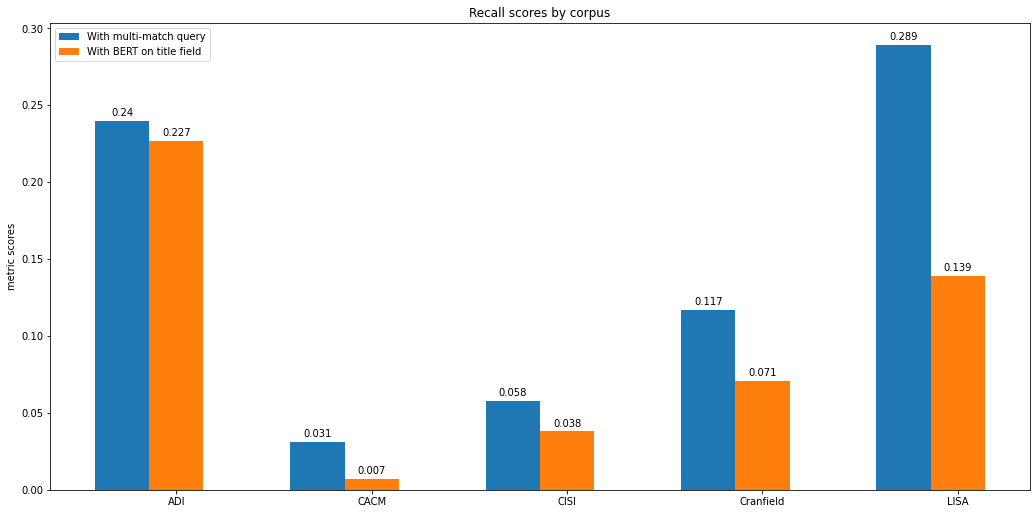

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_recall = []
match_metrics_recall.append(round(adi_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(cacm_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(cisi_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(cran_res_match_recall['metric_score'], 3))
match_metrics_recall.append(round(lisa_res_match_recall['metric_score'], 3))

bert_title_metrics_recall = []
bert_title_metrics_recall.append(round(adi_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(cacm_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(cisi_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(cran_res_bert_title_recall['metric_score'], 3))
bert_title_metrics_recall.append(round(lisa_res_bert_title_recall['metric_score'], 3))

labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA']

x = np.arange(len(labels))*1.8  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_recall , width, label='With multi-match query')
rects2 = ax.bar(x, bert_title_metrics_recall, width, label='With BERT on title field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Recall scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [37]:
from tabulate import tabulate

match_metrics_recall.insert(0, 'multi-match query') 
bert_title_metrics_recall.insert(0, 'BERT on title field')

l = [match_metrics_recall, bert_title_metrics_recall]
table = tabulate(l, headers=['ADI','CACM', 'CISI','cranfield', 'LISA'], tablefmt='orgtbl')

print(table)

|                     |   ADI |   CACM |   CISI |   cranfield |   LISA |
|---------------------+-------+--------+--------+-------------+--------|
| multi-match query   | 0.24  |  0.031 |  0.058 |       0.117 |  0.289 |
| BERT on title field | 0.227 |  0.007 |  0.038 |       0.071 |  0.139 |


### Precision

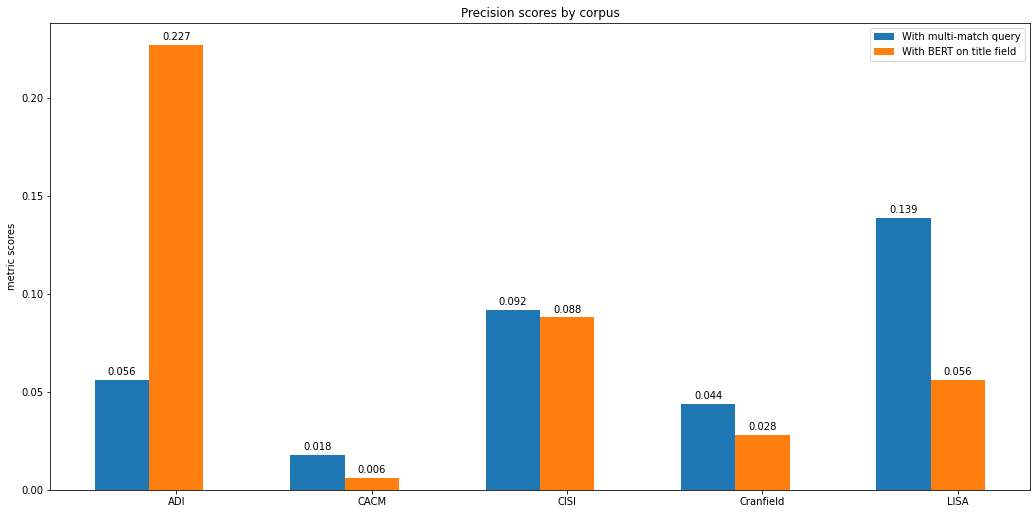

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

match_metrics_precision = []
match_metrics_precision.append(round(adi_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(cacm_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(cisi_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(cran_res_match_precision['metric_score'], 3))
match_metrics_precision.append(round(lisa_res_match_precision['metric_score'], 3))

bert_title_metrics_precision = []
bert_title_metrics_precision.append(round(adi_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(cacm_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(cisi_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(cran_res_bert_title_precision['metric_score'], 3))
bert_title_metrics_precision.append(round(lisa_res_bert_title_precision['metric_score'], 3))

labels = ['ADI','CACM', 'CISI','Cranfield', 'LISA']

x = np.arange(len(labels))*1.8  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_precision , width, label='With multi-match query')
rects2 = ax.bar(x, bert_title_metrics_precision, width, label='With BERT on title field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('Precision scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [39]:
from tabulate import tabulate

match_metrics_precision.insert(0, 'multi-match query') 
bert_title_metrics_precision.insert(0, 'BERT on title field')

l = [match_metrics_precision, bert_title_metrics_precision]
table = tabulate(l, headers=['ADI','CACM', 'CISI','cranfield', 'LISA'], tablefmt='orgtbl')

print(table)

|                     |   ADI |   CACM |   CISI |   cranfield |   LISA |
|---------------------+-------+--------+--------+-------------+--------|
| multi-match query   | 0.056 |  0.018 |  0.092 |       0.044 |  0.139 |
| BERT on title field | 0.227 |  0.006 |  0.088 |       0.028 |  0.056 |


### F-Score

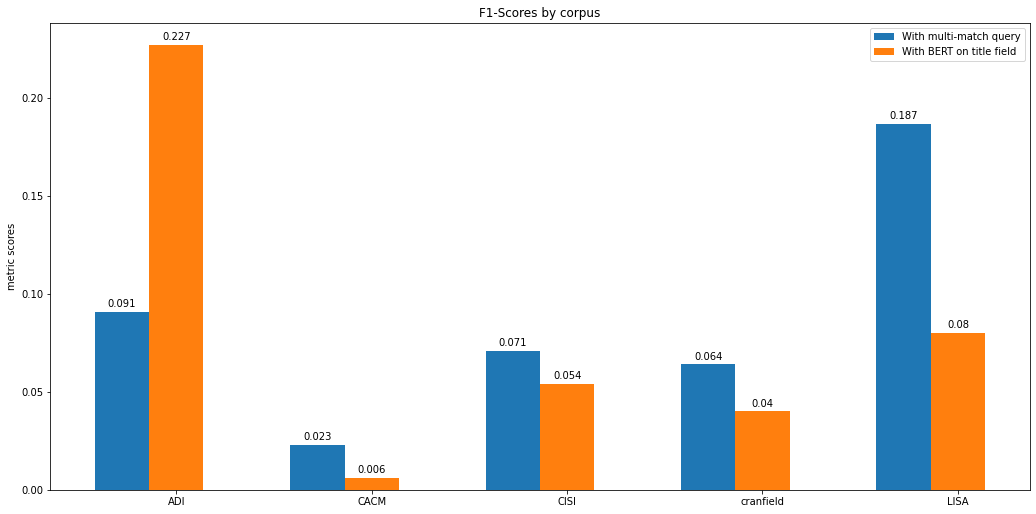

In [40]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def f_score(recall,precision):
  if recall or precision != 0:
    fscore = 2*((recall*precision)/(recall+precision))
    return fscore
  else: return 0

match_metrics_fscore = []
match_metrics_fscore.append(round(f_score(adi_res_match_recall['metric_score'], adi_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(cacm_res_match_recall['metric_score'], cacm_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(cisi_res_match_recall['metric_score'], cisi_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(cran_res_match_recall['metric_score'], cran_res_match_precision['metric_score']),3))
match_metrics_fscore.append(round(f_score(lisa_res_match_recall['metric_score'], lisa_res_match_precision['metric_score']),3))

bert_title_metrics_fscore = []
bert_title_metrics_fscore.append(round(f_score(adi_res_bert_title_recall['metric_score'], adi_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(cacm_res_bert_title_recall['metric_score'], cacm_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(cisi_res_bert_title_recall['metric_score'], cisi_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(cran_res_bert_title_recall['metric_score'], cran_res_bert_title_precision['metric_score']),3))
bert_title_metrics_fscore.append(round(f_score(lisa_res_bert_title_recall['metric_score'], lisa_res_bert_title_precision['metric_score']),3))

labels = ['ADI','CACM', 'CISI','cranfield', 'LISA']

x = np.arange(len(labels))*1.8  # the label locations

width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, match_metrics_fscore , width, label='With multi-match query')
rects2 = ax.bar(x, bert_title_metrics_fscore, width, label='With BERT on title field')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('metric scores')
ax.set_title('F1-Scores by corpus')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
fig.set_figwidth(16)
fig.set_figheight(8)

plt.show()

In [41]:
from tabulate import tabulate

match_metrics_fscore.insert(0, 'multi-match query') 
bert_title_metrics_fscore.insert(0, 'BERT on title field')

l = [match_metrics_fscore, bert_title_metrics_fscore]
table = tabulate(l, headers=['ADI','CACM', 'CISI','cranfield', 'LISA'], tablefmt='orgtbl')

print(table)

|                     |   ADI |   CACM |   CISI |   cranfield |   LISA |
|---------------------+-------+--------+--------+-------------+--------|
| multi-match query   | 0.091 |  0.023 |  0.071 |       0.064 |  0.187 |
| BERT on title field | 0.227 |  0.006 |  0.054 |       0.04  |  0.08  |


Read more on this experiment on our [website](https://pragmalingu.de/docs/experiments/experiment1).